In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from pathlib import Path

PATH = Path.cwd()
PATH_DATA = PATH.parent / 'data'

Leemos los datos del fichero

In [2]:
data = pd.read_csv((PATH_DATA / 'data.csv'), sep=',', index_col=0)

data.head()

,Glándula,SEXO,Edad,Tamaño cálculo,Número de cálculos,Localización cálculo,Extracción cálculo,Preservación glándula,Estenosis
1,SUBMAX,Hombre,19,4.0,1,Retrocaruncular,SÍ,SÍ,NO
2,SUBMAX,Mujer,55,5.0,1,Hilio,SÍ,SÍ,NO
3,SUBMAX,Hombre,50,6.0,1,Hilio,SÍ,SÍ,NO
4,SUBMAX,Hombre,62,3.0,1,Hilio,SÍ,SÍ,NO
5,SUBMAX,Hombre,33,4.0,1,Conducto medio,SÍ,SÍ,NO


## Gráficas de las variables

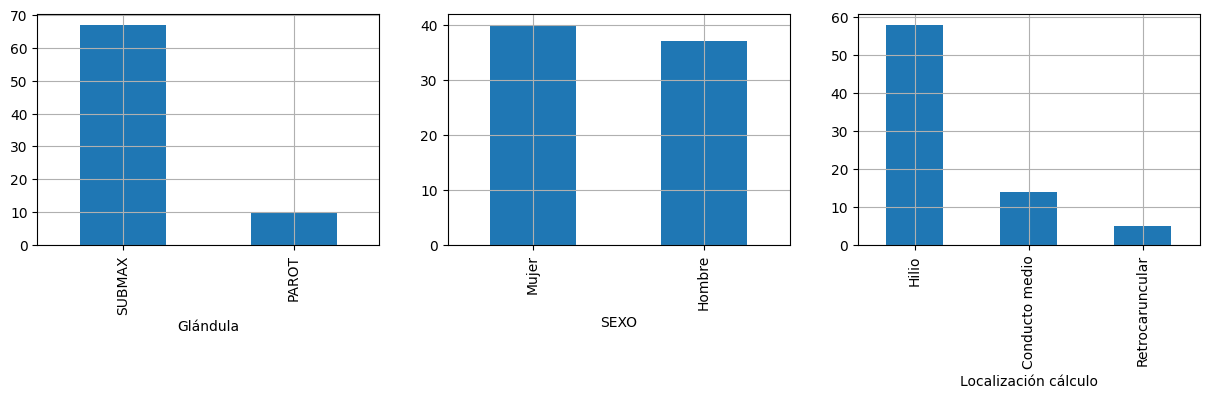

In [3]:
fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15, 3))

data['Glándula'].value_counts().plot(kind='bar', ax=ax[0])
ax[0].grid()

data['SEXO'].value_counts().plot(kind='bar', ax=ax[1])
ax[1].grid()

data['Localización cálculo'].value_counts().plot(kind='bar', ax=ax[2])
ax[2].grid()

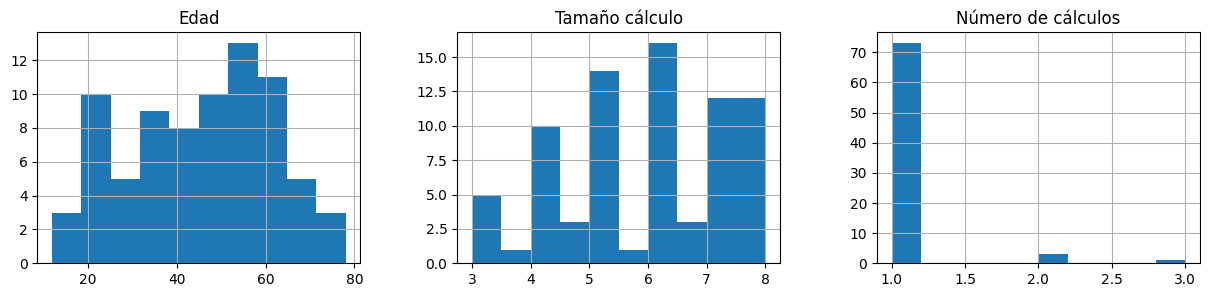

In [4]:
numerical_vars = ['SEXO', 'Edad', 'Tamaño cálculo', 'Número de cálculos']
data[numerical_vars].hist(layout=(1, 3), figsize=(15, 3));

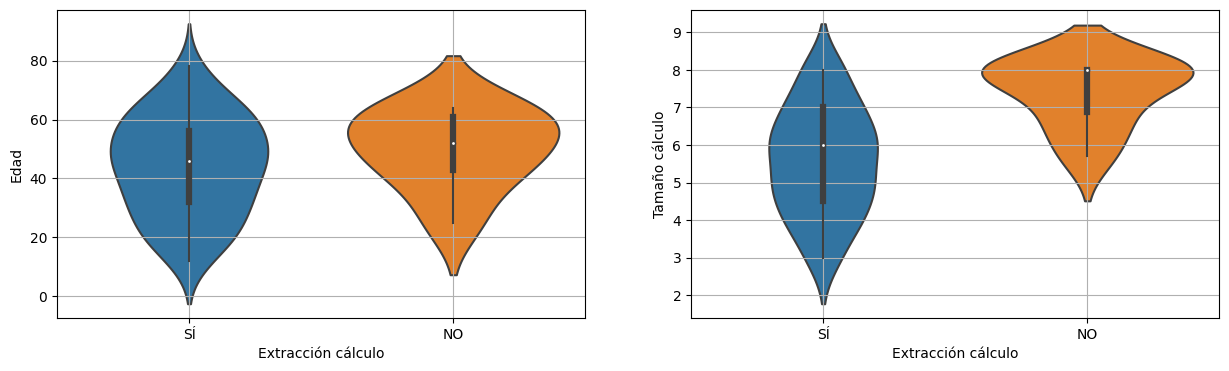

In [5]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

sns.violinplot(data[['Edad', 'Extracción cálculo']], x='Extracción cálculo', y='Edad', ax=ax[0])
ax[0].grid()

sns.violinplot(data[['Tamaño cálculo', 'Extracción cálculo']], x='Extracción cálculo', y='Tamaño cálculo', ax=ax[1])
ax[1].grid()

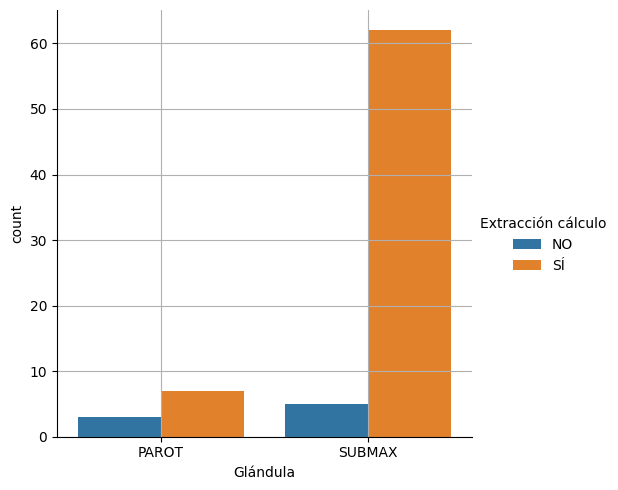

In [6]:
grouped_gland = data[['Glándula', 'Extracción cálculo']].groupby(
    ['Glándula', 'Extracción cálculo']
).value_counts()

grouped_gland = pd.DataFrame(grouped_gland)

grouped_gland['Glándula'] =  grouped_gland.index.get_level_values(0).values
grouped_gland['Extracción cálculo'] =  grouped_gland.index.get_level_values(1).values

sns.catplot(
    x = "Glándula", 
    y = "count", 
    hue = "Extracción cálculo", 
    data = grouped_gland,
    kind = "bar"
)
plt.grid()

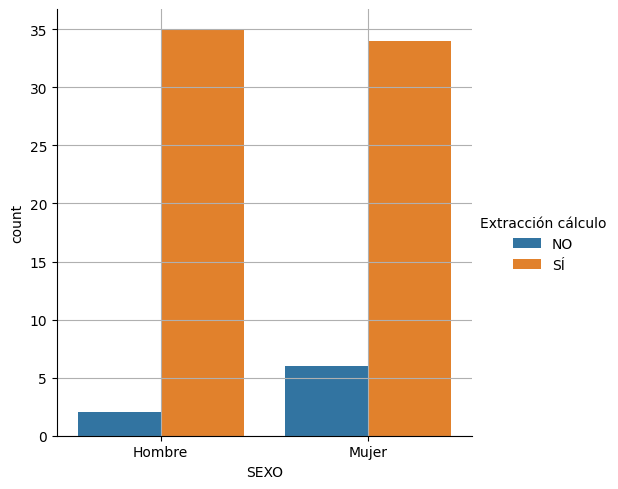

In [7]:
grouped = data[['SEXO', 'Extracción cálculo']].groupby(
    ['SEXO', 'Extracción cálculo']
).value_counts()

grouped = pd.DataFrame(grouped)

grouped['SEXO'] =  grouped.index.get_level_values(0).values
grouped['Extracción cálculo'] =  grouped.index.get_level_values(1).values

sns.catplot(
    x = "SEXO", 
    y = "count", 
    hue = "Extracción cálculo", 
    data = grouped,
    kind = "bar"
)
plt.grid()

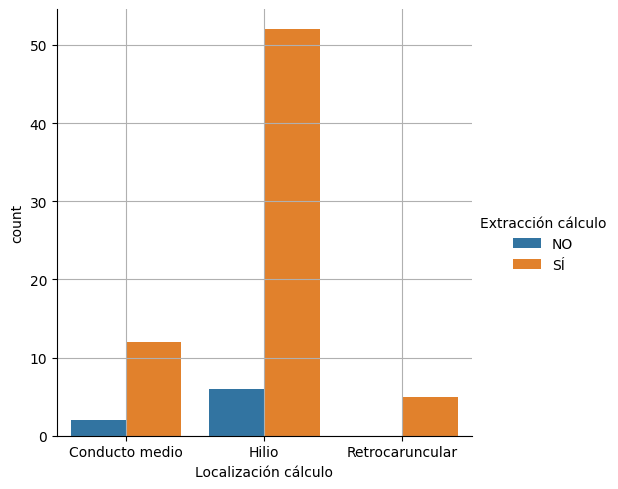

In [8]:
grouped = data[['Localización cálculo', 'Extracción cálculo']].groupby(
    ['Localización cálculo', 'Extracción cálculo']
).value_counts()

grouped = pd.DataFrame(grouped)

grouped['Localización cálculo'] =  grouped.index.get_level_values(0).values
grouped['Extracción cálculo'] =  grouped.index.get_level_values(1).values

sns.catplot(
    x = "Localización cálculo", 
    y = "count", 
    hue = "Extracción cálculo", 
    data = grouped,
    kind = "bar"
)
plt.grid()

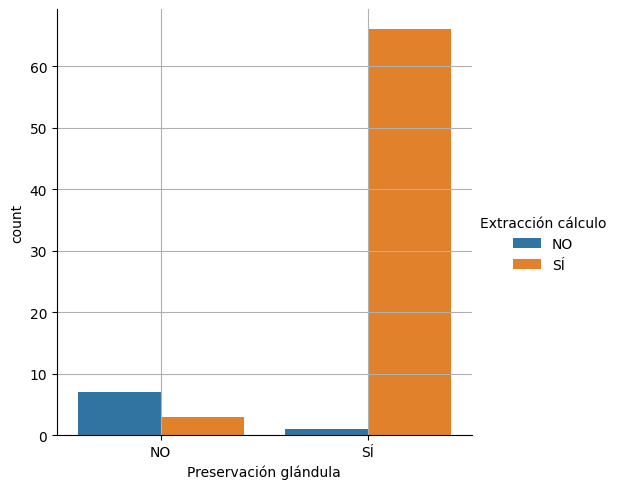

In [9]:
grouped = data[['Preservación glándula', 'Extracción cálculo']].groupby(
    ['Preservación glándula', 'Extracción cálculo']
).value_counts()

grouped = pd.DataFrame(grouped)

grouped['Preservación glándula'] =  grouped.index.get_level_values(0).values
grouped['Extracción cálculo'] =  grouped.index.get_level_values(1).values

sns.catplot(
    x = "Preservación glándula", 
    y = "count", 
    hue = "Extracción cálculo", 
    data = grouped,
    kind = "bar"
)
plt.grid()

In [10]:
np.exp(5.4086)

223.31872251451077

## Modelo

Modificamos las variables para que puedan ser introducidas en el modelo de regresión logística

In [11]:
data.columns = [
    'gland', 'sex', 'age', 'size', 'n_calc', 'loc', 'extracted', 'preserved', 'estenosis'
]

In [12]:
data['gland'] = np.where(data['gland']=='SUBMAX', 1, 0)
data['sex'] = np.where(data['sex']=='Hombre', 1, 0)
data['retrocaruncular'] = np.where(data['loc']=='Retrocaruncular', 1, 0)
data['hilio'] = np.where(data['loc']=='Hilio', 1, 0)
data['extracted'] = np.where(data['extracted']=='NO', 0, 1)
data['preserved'] = np.where(data['preserved']=='NO', 0, 1)
data['estenosis'] = np.where(data['estenosis']=='NO', 0, 1)
data = data.drop('loc', axis=1)

In [13]:
data.to_csv((PATH_DATA / 'data_clean.csv'))

### Ver si cumplen las condiciones de la regresión logística

#### 1 relación lineal entre Xs e Y

In [14]:
data.head()

,gland,sex,age,size,n_calc,extracted,preserved,estenosis,retrocaruncular,hilio
1,1,1,19,4.0,1,1,1,0,1,0
2,1,0,55,5.0,1,1,1,0,0,1
3,1,1,50,6.0,1,1,1,0,0,1
4,1,1,62,3.0,1,1,1,0,0,1
5,1,1,33,4.0,1,1,1,0,0,0


In [15]:
y = data['extracted'].copy()
# Define continuous variables
continuous_var = ['age', 'size', 'n_calc']

# Add logit transform interaction terms (natural log) for continuous variables e.g.. Age * Log(Age)
for var in continuous_var:
    data[f'{var}:Log_{var}'] = data[var].apply(lambda x: x * np.log(x))

# Keep columns related to continuous variables
cols_to_keep = continuous_var + data.columns.tolist()[-len(continuous_var):]

# Redefining variables to include interaction terms
X_lt = data[cols_to_keep]

# Add constant term
X_lt_constant = sm.add_constant(X_lt, prepend=False)
  
# Building model and fit the data (using statsmodel's Logit)
logit_results = sm.GLM(y, X_lt_constant, family=sm.families.Binomial()).fit()

# Display summary results
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              extracted   No. Observations:                   77
Model:                            GLM   Df Residuals:                       70
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13.722
Date:                Mon, 22 May 2023   Deviance:                       27.444
Time:                        13:29:35   Pearson chi2:                     28.6
No. Iterations:                    20   Pseudo R-squ. (CS):             0.2671
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
age                  -0.4921      0.95

#### 2. Multicolinealidad entre las variables

<Axes: >

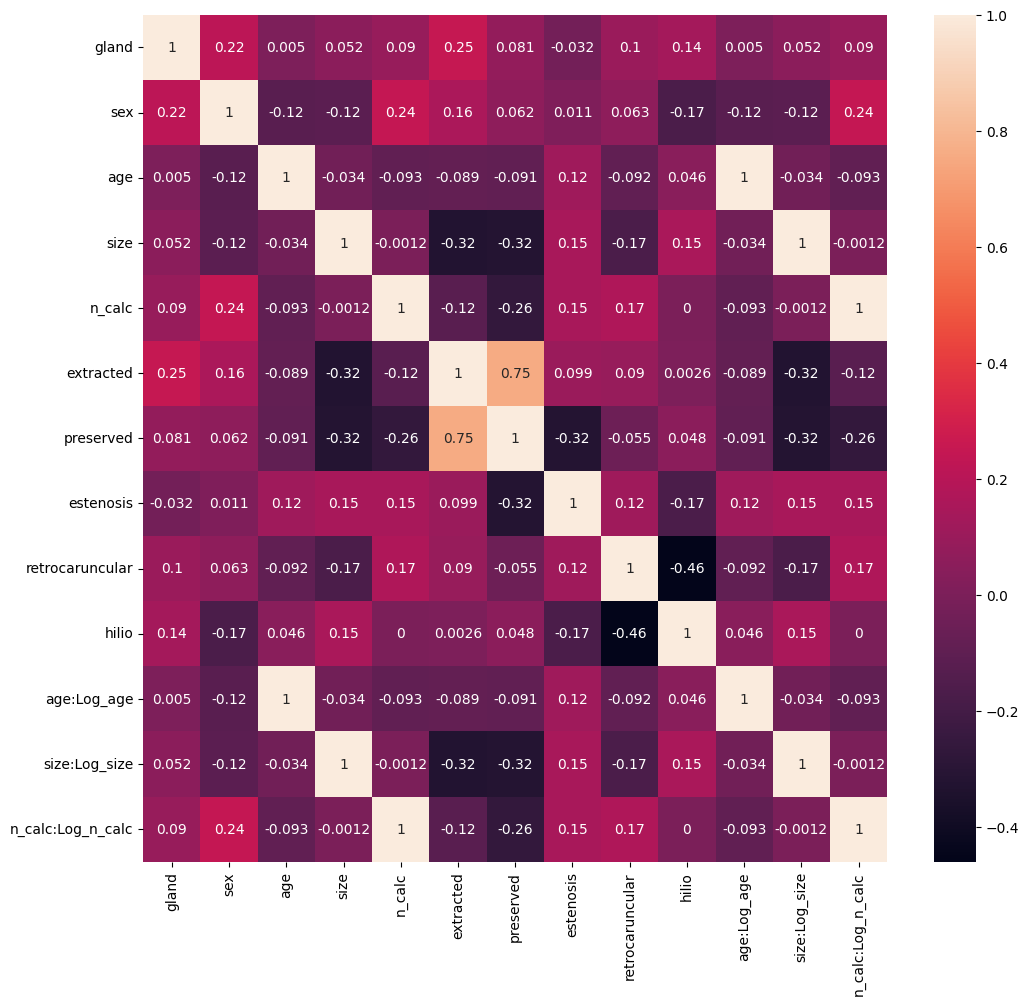

In [16]:
fig, ax = plt.subplots(figsize=(12,11))

sns.heatmap(data.corr(method='kendall'), annot=True, ax=ax)

In [45]:
# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)


In [46]:
variables_x = ['gland', 'size', 'retrocaruncular', 'hilio']
calc_vif(data[variables_x])

,variables,VIF
0,gland,6.841501
1,size,7.240172
2,retrocaruncular,1.337579
3,hilio,5.038570


### Build Model

In [23]:
import statsmodels.formula.api as smf

In [24]:
log_reg = smf.logit(
    "extracted ~ gland + size + retrocaruncular + hilio", data=data
).fit()

print(log_reg.summary())

         Current function value: 0.196203
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:              extracted   No. Observations:                   77
Model:                          Logit   Df Residuals:                       72
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 May 2023   Pseudo R-squ.:                  0.4118
Time:                        13:31:24   Log-Likelihood:                -15.108
converged:                      False   LL-Null:                       -25.684
Covariance Type:            nonrobust   LLR p-value:                 0.0002953
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          11.4425      4.289      2.668      0.008       3.036      19.849
gland               3.3900      1.466      2.312  

/home/javier/miniconda3/envs/thesis/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
